# RFM Analysis - full analysis
This notebook shows how I do customer segmentation using RFM (Recency, Frequency, and Monetary) analysis combined with K-Means clustering to identify different customer groups based on purchasing behavior. The dataset used for this analysis was obtained from [here](https://archive.ics.uci.edu/dataset/502/online+retail+ii).

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import warnings
warnings.filterwarnings('ignore')

## Quick Overview

In [2]:
#Load the dataset

df1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [3]:
#Merge the two datasets
df = pd.concat([df1, df2], ignore_index=True)

In [4]:
#Add "Amount" column
df['Amount'] = df['Quantity'] * df['Price']

In [5]:
#Check the number of rows and columns in the dataset
df.shape

(1067371, 9)

In [6]:
#See the first 10 rows
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.6
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,59.5
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.6
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,45.0


In [7]:
#Rename columns
df.rename(columns={
    'StockCode': 'Stock Code',
    'InvoiceDate': 'Invoice Date',
    'Price': 'Unit Price'
}, inplace=True)

In [8]:
#Show dataset summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Invoice       1067371 non-null  object        
 1   Stock Code    1067371 non-null  object        
 2   Description   1062989 non-null  object        
 3   Quantity      1067371 non-null  int64         
 4   Invoice Date  1067371 non-null  datetime64[ns]
 5   Unit Price    1067371 non-null  float64       
 6   Customer ID   824364 non-null   float64       
 7   Country       1067371 non-null  object        
 8   Amount        1067371 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 73.3+ MB


In [9]:
#Summary statistics
df.describe()

,Quantity,Invoice Date,Unit Price,Customer ID,Amount
count,1.067371e+06,1067371,1.067371e+06,824364.000000,1.067371e+06
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504,1.806987e+01
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000,-1.684696e+05
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000,3.750000e+00
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000,9.900000e+00
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000,1.770000e+01
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000,1.684696e+05
std,1.727058e+02,NaN,1.235531e+02,1697.464450,2.924202e+02


## Data Cleaning

### Handling Missing Values

In [10]:
#Check for missing values
df.isna().sum()

Invoice              0
Stock Code           0
Description       4382
Quantity             0
Invoice Date         0
Unit Price           0
Customer ID     243007
Country              0
Amount               0
dtype: int64

#### Handling Missing Values in "Description" column

In [11]:
#Make product descriptions uppercase
df['Description'] = df['Description'].str.upper()

In [12]:
#Check the number of unique values
df['Description'].nunique()

5671

In [13]:
#Show rows with missing values
df[df['Description'].isnull()]

,Invoice,Stock Code,Description,Quantity,Invoice Date,Unit Price,Customer ID,Country,Amount
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom,-0.0
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom,-0.0
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom,0.0
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom,0.0
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom,-0.0
...,...,...,...,...,...,...,...,...,...
1060783,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom,-0.0
1060787,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom,0.0
1060793,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom,0.0
1062442,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom,0.0


In [14]:
#Drop rows with null values
df = df.dropna(subset=['Description'])

In [15]:
#Check the number of descriptions after cleaning
len(df['Description'])

1062985

#### Handling Missing Values in "Customer ID" column

In [16]:
#Show rows with missing values
df[df['Customer ID'].isnull()]

,Invoice,Stock Code,Description,Quantity,Invoice Date,Unit Price,Customer ID,Country,Amount
263,489464,21733,85123A MIXED,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom,-0.00
283,489463,71477,SHORT,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom,-0.00
284,489467,85123A,21733 MIXED,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom,-0.00
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,0.55
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom,0.85
...,...,...,...,...,...,...,...,...,...
1066997,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom,20.65
1066998,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom,16.52
1066999,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom,4.96
1067000,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom,10.79


In [17]:
#Get the total count of null values
df['Customer ID'].isnull().sum()

238621

In [18]:
#Drop rows with null values
df = df.dropna(subset=['Customer ID'])

### Handling Duplicates Data

In [19]:
#Check for duplicate rows
df.duplicated().sum()

26479

In [20]:
#Drop duplicates
df = df.drop_duplicates()

### Check and Handling Column One by One

#### "Invoice" Column

In [21]:
#Change the data type to string
df['Invoice'] = df['Invoice'].astype(str)

In [22]:
#Checking for orders starting with "C" indicating cancellations
df[df['Invoice'].str.startswith('C')]

,Invoice,Stock Code,Description,Quantity,Invoice Date,Unit Price,Customer ID,Country,Amount
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.40
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,-9.90
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,-17.00
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,-12.60
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.40
...,...,...,...,...,...,...,...,...,...
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13
1067002,C581499,M,MANUAL,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25


In [23]:
#Drop cancelled orders
df = df[~df['Invoice'].astype(str).str.startswith('C')]

#### "Stock Code" Column

In [24]:
#Change data type to string
df['Stock Code'] = df['Stock Code'].astype(str)

#### "Description" Column

In [25]:
#Check for incorrect values
unwanted = ["ADJUSTMENT", "BROKEN", "WET", "CRUSHED", "DAMAGED", "DAMAGES", "DAMP", "DIRTY", "DONATED", "INCORRECT", 
            "LOST", "GONE", "MISSING", "MOULDY", "SMASHED", "WRONG", "ERROR", "WRONGLY", "OOPS", "CARGO", "COUNTED", 
            "DISCOLOURED", "DISCOUNT", "EBAY", "FAULTY", "FOUND", "GIVEN", "MANUAL", "NO STOCK", 
            "NON COLOUR", "REVERSE", "REX USE", "RUSTY", "SHORT", "UPDATE", "BROKEN WONKY", 
            "SAMPLES", "TAIG", "THROUGH", "UNSALEABLE", "WEBSITE", "FIND", "MARKED", "NEXT"]

df[df["Description"].str.upper().str.contains("|".join(unwanted))]["Description"].unique()

array(['MANUAL', 'ADJUSTMENT BY JOHN ON 26/01/2010 16',
       'ADJUSTMENT BY JOHN ON 26/01/2010 17', 'DISCOUNT',
       'ADJUSTMENT BY PETER ON JUN 25 2010 ', 'NEXT DAY CARRIAGE'],
      dtype=object)

In [26]:
#Drop descriptions containing unwanted keywords
df = df[~df['Description'].str.upper().str.contains("|".join(unwanted), na=False)]

#### "Quantity" Column

In [27]:
#Check how many negative quantities exist
(df['Quantity'] < 0).sum()

0

#### "Unit Price" Column

In [28]:
#Check how many negative unit prices exist
(df['Unit Price'] < 0).sum()

0

In [29]:
#Show zero-priced items
df[df['Unit Price'] == 0]

,Invoice,Stock Code,Description,Quantity,Invoice Date,Unit Price,Customer ID,Country,Amount
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126.0,United Kingdom,0.0
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.0,15658.0,United Kingdom,0.0
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.0,14108.0,United Kingdom,0.0
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.0,14108.0,United Kingdom,0.0
32916,492079,85042,ANTIQUE LILY FAIRY LIGHTS,8,2009-12-15 13:49:00,0.0,15070.0,United Kingdom,0.0
...,...,...,...,...,...,...,...,...,...
979924,575579,22437,SET OF 9 BLACK SKULL BALLOONS,20,2011-11-10 11:49:00,0.0,13081.0,United Kingdom,0.0
979925,575579,22089,PAPER BUNTING VINTAGE PAISLEY,24,2011-11-10 11:49:00,0.0,13081.0,United Kingdom,0.0
1004540,577129,22464,HANGING METAL HEART LANTERN,4,2011-11-17 19:52:00,0.0,15602.0,United Kingdom,0.0
1006110,577314,23407,SET OF 2 TRAYS HOME SWEET HOME,2,2011-11-18 13:23:00,0.0,12444.0,Norway,0.0


In [30]:
#Keep only rows with positive unit prices
df = df[df['Unit Price'] > 0]

#### "Customer ID" Column

In [31]:
#Change data type to string
df['Customer ID'] = df['Customer ID'].astype(str)

In [32]:
#Replace the decimal
df['Customer ID'] = df['Customer ID'].str.replace('\.0$', '', regex=True)

#### "Country" Column

In [33]:
#Change the data type to string
df['Country'] = df['Country'].astype(str)

In [34]:
#Show unique values 
df['Country'].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Denmark', 'Netherlands', 'Poland',
       'Channel Islands', 'Spain', 'Cyprus', 'Greece', 'Norway',
       'Austria', 'Sweden', 'United Arab Emirates', 'Finland', 'Italy',
       'Switzerland', 'Japan', 'Unspecified', 'Malta', 'RSA', 'Singapore',
       'Bahrain', 'Thailand', 'Israel', 'Lithuania', 'Nigeria',
       'West Indies', 'Korea', 'Brazil', 'Canada', 'Iceland', 'Lebanon',
       'Saudi Arabia', 'Czech Republic', 'European Community'],
      dtype=object)

In [35]:
#Show rows where "Country" is unspecified
df[df['Country'] == 'Unspecified']

,Invoice,Stock Code,Description,Quantity,Invoice Date,Unit Price,Customer ID,Country,Amount
61394,494860,84832,ZINC WILLIE WINKIE CANDLE STICK,5,2010-01-19 11:01:00,0.85,12470,Unspecified,4.25
61395,494860,84836,ZINC METAL HEART DECORATION,5,2010-01-19 11:01:00,1.25,12470,Unspecified,6.25
61396,494860,85014D,PINK/BROWN DOTS RUFFLED UMBRELLA,1,2010-01-19 11:01:00,5.95,12470,Unspecified,5.95
61397,494860,85014A,BLACK/BLUE DOTS RUFFLED UMBRELLA,1,2010-01-19 11:01:00,5.95,12470,Unspecified,5.95
61398,494860,85014B,RED/WHITE DOTS RUFFLED UMBRELLA,2,2010-01-19 11:01:00,5.95,12470,Unspecified,11.90
...,...,...,...,...,...,...,...,...,...
834271,564051,23007,SPACEBOY BABY GIFT SET,1,2011-08-22 13:32:00,16.95,14265,Unspecified,16.95
834272,564051,21833,CAMOUFLAGE LED TORCH,12,2011-08-22 13:32:00,1.69,14265,Unspecified,20.28
834273,564051,23081,GREEN METAL BOX ARMY SUPPLIES,2,2011-08-22 13:32:00,8.25,14265,Unspecified,16.50
834274,564051,23046,PAPER LANTERN 9 POINT DELUXE STAR,2,2011-08-22 13:32:00,6.65,14265,Unspecified,13.30


In [36]:
#Number of 'Unspecified' countries
(df['Country'] == 'Unspecified').sum()

518

In [37]:
#Filter out 'Unspecified' countries
df = df[df['Country'] != 'Unspecified']

### Check the Cleaned Data

In [38]:
df.head()

,Invoice,Stock Code,Description,Quantity,Invoice Date,Unit Price,Customer ID,Country,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 778107 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Invoice       778107 non-null  object        
 1   Stock Code    778107 non-null  object        
 2   Description   778107 non-null  object        
 3   Quantity      778107 non-null  int64         
 4   Invoice Date  778107 non-null  datetime64[ns]
 5   Unit Price    778107 non-null  float64       
 6   Customer ID   778107 non-null  object        
 7   Country       778107 non-null  object        
 8   Amount        778107 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 59.4+ MB


In [40]:
df.describe()

,Quantity,Invoice Date,Unit Price,Amount
count,778107.000000,778107,778107.000000,778107.000000
mean,13.493189,2011-01-03 02:36:50.296449792,3.026507,22.115920
min,1.000000,2009-12-01 07:45:00,0.001000,0.001000
25%,2.000000,2010-07-02 14:39:00,1.250000,4.950000
50%,6.000000,2010-12-02 14:40:00,1.950000,12.480000
75%,12.000000,2011-08-01 16:41:00,3.750000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,168469.600000
std,145.953793,NaN,11.231755,225.963973


In [41]:
#Export cleaned data to excel
#df.to_excel("Data Cleaned (RFM).xlsx", index=False)

## RFM Analysis

In [42]:
#Snapshot date: a day after last transaction
snapshot_date = df['Invoice Date'].max() + pd.Timedelta(days=1)

In [43]:
#Calculate RFM metrics
rfm = df.groupby('Customer ID').agg({
    'Invoice Date': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'Amount': 'sum'
})

#Rename columns
rfm.rename(columns={
    'Invoice Date': 'Recency',
    'Invoice': 'Frequency',
    'Amount': 'Monetary'
}, inplace=True)

#Reset index to convert "Customer ID" from index to a column
rfm = rfm.reset_index()

#See the first 5 rows of RFM
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346,326,12,77556.46
1,12347,2,8,4921.53
2,12348,75,5,2019.40
3,12349,19,4,4428.69
4,12350,310,1,334.40


### Check the Distribution of RFM Metrics

#### Before Log Transformation

Text(0.5, 1.0, 'Recency Distribution')

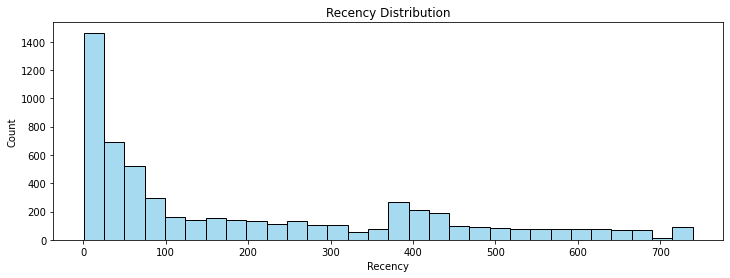

In [44]:
# ----- Recency -----
plt.figure(figsize=(12, 4))

sns.histplot(data=rfm, x='Recency', bins=30, color='skyblue')
plt.title('Recency Distribution')

Text(0.5, 1.0, 'Frequency Distribution')

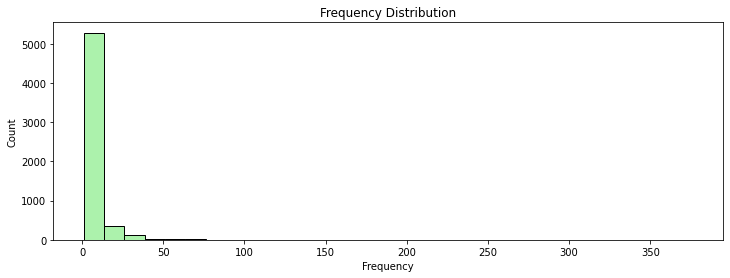

In [45]:
# ----- Frequency -----
plt.figure(figsize=(12, 4))

sns.histplot(data=rfm, x='Frequency', bins=30, color='lightgreen')
plt.title('Frequency Distribution')

Text(0.5, 1.0, 'Monetary Distribution')

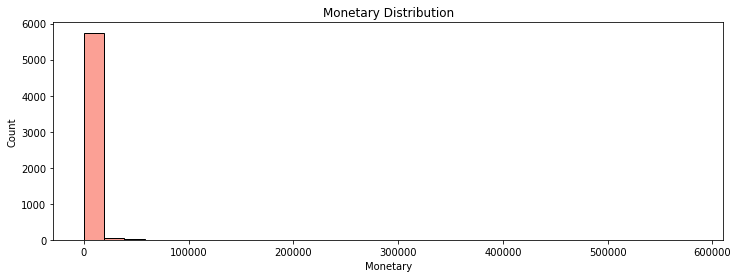

In [46]:
# ----- Monetary -----
plt.figure(figsize=(12, 4))

sns.histplot(data=rfm, x='Monetary', bins=30, color='salmon')
plt.title('Monetary Distribution')

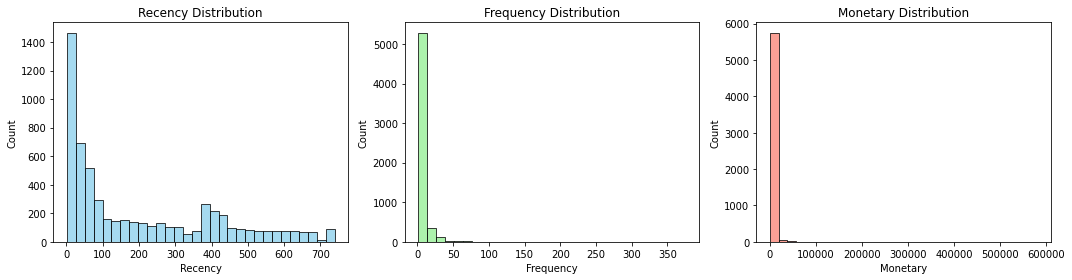

In [47]:
plt.figure(figsize=(15, 4))

#Recency
plt.subplot(1, 3, 1)
sns.histplot(data=rfm, x='Recency', bins=30, color='skyblue')
plt.title('Recency Distribution')

#Frequency
plt.subplot(1, 3, 2)
sns.histplot(data=rfm, x='Frequency', bins=30, color='lightgreen')
plt.title('Frequency Distribution')

#Monetary
plt.subplot(1, 3, 3)
sns.histplot(data=rfm, x='Monetary', bins=30, color='salmon')
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

#### After Log Transformation

In [48]:
#Copy RFM columns for visualization
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].copy()

In [49]:
#Apply log transformation to reduce skewness in RFM variables
rfm_log['Recency_log'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency_log'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary_log'] = np.log1p(rfm_log['Monetary'])

Text(0.5, 1.0, 'Recency (log) Distribution')

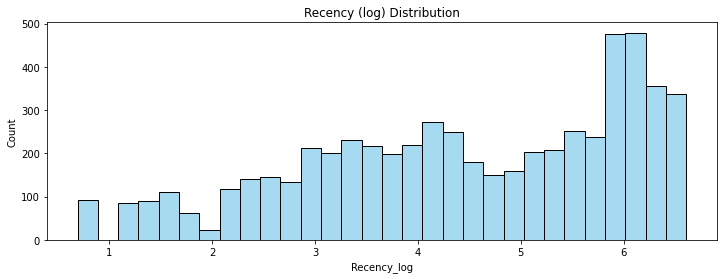

In [50]:
#Create the visualization
# ----- Recency -----
plt.figure(figsize=(12, 4))

sns.histplot(data=rfm_log, x='Recency_log', bins=30, color='skyblue')
plt.title('Recency (log) Distribution')

Text(0.5, 1.0, 'Frequency (log) Distribution')

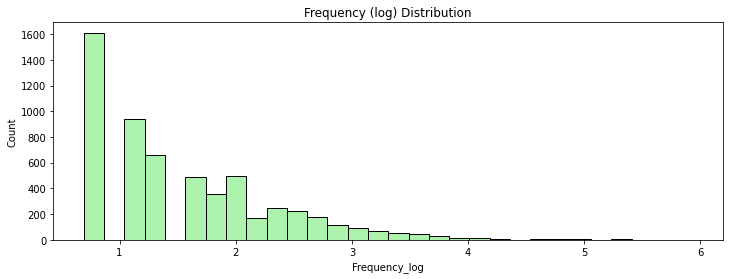

In [51]:
# ----- Frequency -----
plt.figure(figsize=(12, 4))

sns.histplot(data=rfm_log, x='Frequency_log', bins=30, color='lightgreen')
plt.title('Frequency (log) Distribution')

Text(0.5, 1.0, 'Monetary (log) Distribution')

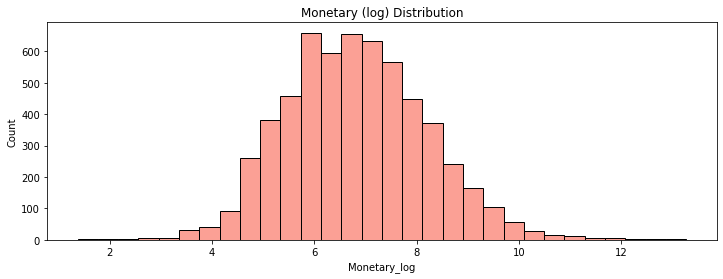

In [52]:
# ----- Monetary -----
plt.figure(figsize=(12, 4))

sns.histplot(data=rfm_log, x='Monetary_log', bins=30, color='salmon')
plt.title('Monetary (log) Distribution')

## Clustering with K-Means

### Data Preprocessing

In [53]:
#Standardize RFM features using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

### Finding the Optimal Number of Clusters

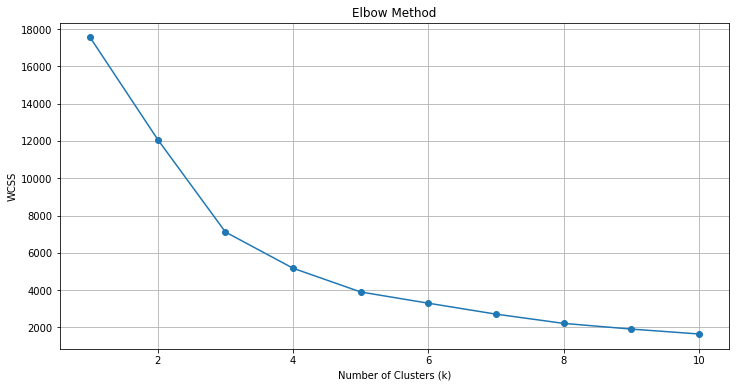

In [54]:
#Use the Elbow Method to determine the optimal number of clusters for K-Means
from sklearn.cluster import KMeans

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

### Silhouette Score

In [55]:
#Evaluate clustering quality using silhouette scores for k=2 to 10
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    print(f"Silhouette Score for {k} clusters: {score:.4f}")

Silhouette Score for 2 clusters: 0.9160
Silhouette Score for 3 clusters: 0.5814
Silhouette Score for 4 clusters: 0.5901
Silhouette Score for 5 clusters: 0.6028
Silhouette Score for 6 clusters: 0.5472
Silhouette Score for 7 clusters: 0.5475
Silhouette Score for 8 clusters: 0.5400
Silhouette Score for 9 clusters: 0.5409
Silhouette Score for 10 clusters: 0.5004


### Applying K-Means Clustering

In [56]:
#Assign clusters to customers using K-Means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [57]:
#Summary statistics of RFM and customer count by cluster
rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'
}).round(1).rename(columns={'Customer ID': 'The Number of Customers'}).reset_index()

,Cluster,Recency,Frequency,Monetary,The Number of Customers
0,0,67.1,7.2,2907.3,3830
1,1,461.8,2.2,729.0,1976
2,2,24.3,99.4,77347.9,38
3,3,3.5,204.2,423450.6,4


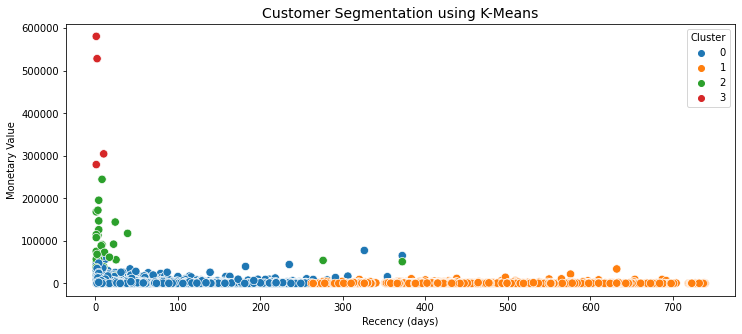

In [58]:
#Scatterplot of clusters based on Recency and Monetary
plt.figure(figsize=(12,5))

sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10', s=70)
plt.title('Customer Segmentation using K-Means', fontsize=14)
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value')
plt.show()

In [59]:
#Create a mapping of cluster labels to segment names
segment_map={
    0: 'Reguler Customers',
    1: 'Churned Customers',
    2: 'Loyal Customers',
    3: 'New Customers'
}

#Add a new column "Segment" based on cluster mapping
rfm['Segment'] = rfm['Cluster'].map(segment_map)

In [60]:
#See the first 5 rows of the final RFM data
rfm.head()

,Customer ID,Recency,Frequency,Monetary,Cluster,Segment
0,12346,326,12,77556.46,0,Reguler Customers
1,12347,2,8,4921.53,0,Reguler Customers
2,12348,75,5,2019.40,0,Reguler Customers
3,12349,19,4,4428.69,0,Reguler Customers
4,12350,310,1,334.40,1,Churned Customers


In [61]:
#Export final RFM dataset to excel
#rfm.to_excel("RFM Data.xlsx", index=False)